<a href="http://landlab.github.io"><img style="float: left" src="../../landlab_header.png"></a>

# Comparison of FlowDirectors

## Introduction

Landlab's topographic flow-routing capability directs flow and accumulates it using two types of components:

**FlowDirectors** use the topography to determine ***how flow moves between adjacent nodes***. For every node in the grid it determines the node(s) to receive flow, and the proportion of flow to send from one node to its receiver(s). 

The **FlowAccumulator** uses the ***direction and proportion*** of flow moving between each node and (optionally) ***water runoff*** to calculate drainage area and discharge. 

The **FlowDirectors** are method-specific. Presently landlab supports four different methods for determining flow direction:

1. **FlowDirectorSteepest** Flow is routed to ***only one node***. The algorithm considers the ***link slopes*** leaving from each node and chooses the steepest downhill link to route flow along. In the case of a raster grid, only the links are considered (Landlab differentiates between *links*, which never cross and are located at North, South, East, and West on a raster grid, and *diagonals* which cross and are located at North East, North West, South East, and South West). For raster grids, this method is also known as D4 flow routing. In the case of irregular grids, all links originating from a node are consideded.

2. **FlowDirectorD8** (raster only) Flow is only routed to ***one node but diagonals are also considered***. 

3. **FlowDirectorMFD** Flow is directed to all nodes that are located downhill of the source node. In the case of a raster grid, diagonals can be included using the keyword ***```diagonals=True```***. Flow is partitioned between receiver nodes based on the relative slope along the links leading to the receiver nodes. The default method for partitioning is based on the sum of receiver slopes ***(```partition_method='slope'```)***. Partitioning can also be done on the basis of the square root of slope, which gives the result of a steady kinematic wave ***(```partition_method='square_root_of_slope'```)***.

4. **FlowDirectorDINF** (raster only) Flow is directed to ***two cells*** based on the slope of the triangular facets that can be defined between a node and its neighbors. The steepest downhill facet is chosen and then flow is partitioned between the receiver nodes at the bottom of that facet based on the relative slopes along the facet-bounding links. (The method, known as "D-infinity", is described by Tarboton (1997, Water Resources Research, 33(2), 309-319)).

In this tutorial we will go over more detailed examples that contrast the differences between each flow-direction algorithm. For information about how to initialize and run a **FlowDirector** or the **FlowAccumulator**, refer to the other tutorials in this section. 

First, we import the necessary python modules and make a small plotting routine. 

In [1]:
%matplotlib inline

In [2]:
# import necessary landlab components we explore in this tutorial
from landlab import RasterModelGrid, HexModelGrid

from landlab.components import FlowAccumulator
from landlab.components import(FlowDirectorD8, 
                               FlowDirectorDINF, 
                               FlowDirectorMFD, 
                               FlowDirectorSteepest)


# import plotting tools
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib as mpl

# import numpy
import numpy as np



# import landlab plotting functionality
from landlab.plot.drainage_plot import drainage_plot

# create a plotting routine to make a 3D plot of our surface. 
def surf_plot(mg, surface='topographic__elevation', title='Surface plot of topography'):
    
    fig = plt.figure()
    ax = fig.gca(projection='3d')

    # Plot the surface.
    Z = mg.at_node[surface].reshape(mg.shape)
    color = cm.gray((Z-Z.min())/(Z.max()-Z.min()))
    surf = ax.plot_surface(mg.x_of_node.reshape(mg.shape), mg.y_of_node.reshape(mg.shape), 
                           Z,
                           rstride=1, cstride=1,
                           facecolors=color,
                           linewidth=0., 
                           antialiased=False)
    ax.view_init(elev=35, azim=-120)
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Elevation')
    plt.title(title)
    plt.show()

## Topographic grid: curved surface

For this tutorial we will consider a curved topographic surface that looks like an upland hollow topography. We will use this to highlight the difference between each of the flow direction algorithms. 

/tmp/ipykernel_172478/2363164735.py:30: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


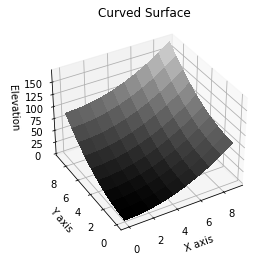

In [3]:
mg = RasterModelGrid((10,10))
_ = mg.add_field('topographic__elevation',
                  mg.x_of_node**2. + mg.y_of_node**2. + mg.y_of_node,
                  at='node')
surf_plot(mg, title='Curved Surface')

# Comparing the different methods 

We can illustrate the receiver node **FlowDirectionSteepest** has assigned to each donor node using a plotting function in Landlab called ```drainage_plot```. We will see many of these plots in this tutorial so let's take a moment to walk through the plot and what it contains. 

- The background image (white to black) shows the values of topographic elevation of the underlying surface.

- The color of the dots inside of each pixel show the locations of the nodes and the type of node. 

- The arrows show the direction of flow, and the color shows the proportion of flow that travels along that link. 

- An X on top of a node indicates that node is a local sink and flows to itself. 

Note that in Landlab *boundary nodes*, or nodes that are on the edge of a grid do not have area and do not contribute flow to nodes. These nodes can either be *Fixed Gradient Nodes*, *Fixed Value Nodes*, or *Closed Nodes*. With the exception of *Closed Nodes* the boundary nodes can receive flow. 

An important step in all flow direction and accumulation is setting the proper boundary condition. Refer to the boundary condition tutorial for more information. 



In the examples below we will explore different **FlowDirection** methods by first running and mapping them on the grid, then running a **FlowAccumulator** to explore the differences in the accumulated drainge are patterns.

## FlowDirectors

**(a) FlowDirectorSteepest** let's start with routing flow to the steepest direction of the outgoing links of a node. 

In [4]:
#FlowDirectorSteepest?

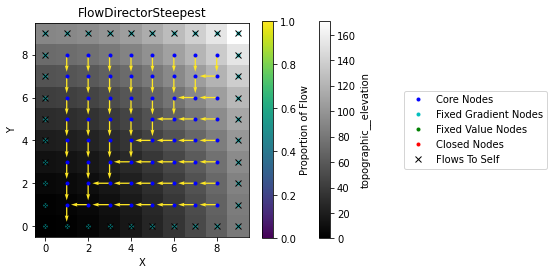

In [6]:
mga = RasterModelGrid((10,10))   
_ = mga.add_field('topographic__elevation',
                   mga.x_of_node**2 + mga.y_of_node**2 + mga.y_of_node,
                   at = 'node')

fd = FlowDirectorSteepest(mga, 'topographic__elevation')   # instantiate the component

fd.run_one_step()     # perform a one-time run

plt.figure()   
drainage_plot(mga, title='FlowDirectorSteepest')

Reassuringly we can see that the flow is being sent from **high elevations at the top of the grid to low elevations** at the bottom of the grid. We can also see that all of the arrows are **yellow**, and thus **all of the flow** is traveling on these links. Because the algorithm uses the outgoing links, not diagonals, the flow networks looks like a **pipe network**. Note that if boundary conditions are not specified, Landlab makes fixed value "outlet" assumption for all sides of the domain. You can change this by commenting out the line after grid creation and see what happens.

Here we will run **FlowAccumulator** which internally impelements a flow direction algorithm chosen by the user. We will cover flow accumulation in greater detail later. Here let's implement FlowAccumulator by specifying the option as the last statement of the call below. 

In [7]:
#FlowAccumulator?

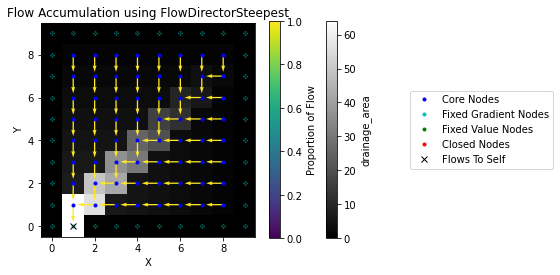

In [8]:
fa = FlowAccumulator(mga, 'topographic__elevation', flow_director='Steepest') # instantiate the component

fa.run_one_step()  # run it once

plt.figure()    # # drainge plot from Landlab plotting functions
drainage_plot(mga, 'drainage_area', title='Flow Accumulation using FlowDirectorSteepest')

Flow accumulator in this example adds the cells along the flow direction. As water can only flow in one direction, all the cells accumulate at a single most downstream cell. Let's take a quick look at the grid attributes to relate with the accumulated flow figure:

In [8]:
print('number of nodes=', mga.number_of_nodes)
print('number of links=', mga.number_of_links)
print('number of core nodes=', mga.number_of_core_nodes)
print('number of cells=', mga.number_of_cells)

number of nodes= 100
number of links= 180
number of core nodes= 64
number of cells= 64


**(b) FlowDirectorD8:** D8 algorithm sends the flow to one of the 8 neighbors (downstream) of the source node.

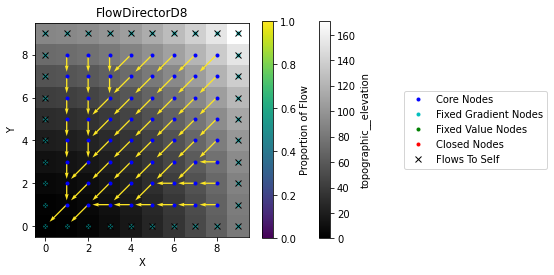

In [10]:
mgb = RasterModelGrid((10,10))
_ = mgb.add_field('topographic__elevation',
                   mgb.x_of_node**2 + mgb.y_of_node**2 + mgb.y_of_node,
                   at = 'node')

fdb = FlowDirectorD8(mgb)

fdb.run_one_step()

plt.figure()
drainage_plot(mgb, title='FlowDirectorD8')

Near the bottom left of the grid, the steepest descent is on a diagonal, so using **FlowDirectorD8** gives a different drainage pattern. 

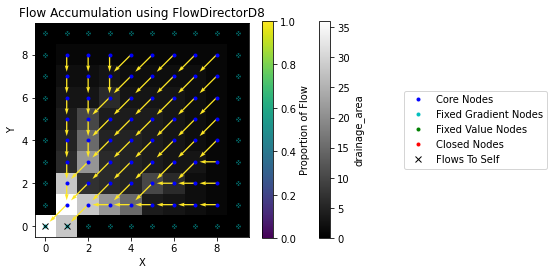

In [11]:
fa = FlowAccumulator(mgb, 'topographic__elevation', flow_director='D8')

fa.run_one_step()

plt.figure()
drainage_plot(mgb, 'drainage_area', title='Flow Accumulation using FlowDirectorD8')

When diagonals are included (that is D8) the flow concentrates on the sides of the domain. Because we did not force the flow to a single outlet some of the flow spills on the side of the hollow from the second grid.

**(c) FlowDirectorDINF:** Flow is directed to two cells based on the slope of the triangular facets that can be defined between a node and its neighbors. 

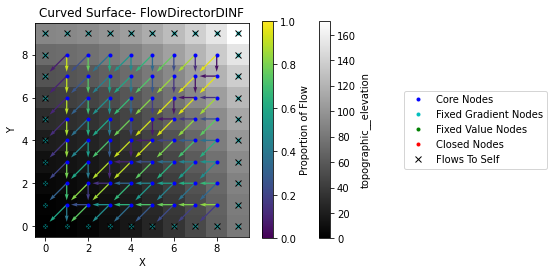

In [12]:
mgc = RasterModelGrid((10,10))
_ = mgc.add_field('topographic__elevation',
                   mgc.x_of_node**2 + mgc.y_of_node**2 + mgc.y_of_node,
                   at='node')

fdc = FlowDirectorDINF(mgc)

fdc.run_one_step()

plt.figure()
drainage_plot(mgc, title='Curved Surface- FlowDirectorDINF')

Finally we see yet a different drainage pattern when we use **FlowDirectorDINF** and flow is routed along an adjacent diagonal-link pair. Here **FlowDirectorDINF** routes flow in two directions, to the south and southeast. The plane is steeper to from north to south than from east to west and so more flow is directed on the diagonal to the southeast. 


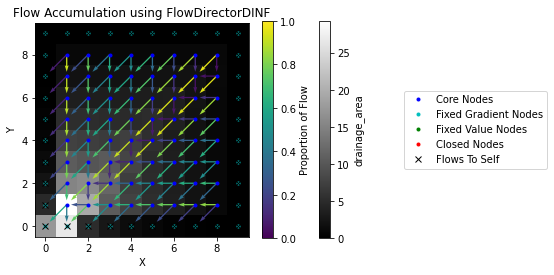

In [13]:
fa = FlowAccumulator(mgc, 'topographic__elevation', flow_director='DINF')

fa.run_one_step()

plt.figure()
drainage_plot(mgc, 'drainage_area', title='Flow Accumulation using FlowDirectorDINF')


DINF also gives a difused pattern of flow accumulation that closely represent overlandflow.

# Break out session

1. First restart your kernel and clear out the data. 
2. Bring the Hugo Basin here and map it
3. Run the D8 flow direction algorithm as part of the flow accumulator component.
4. Map your drainge areas using **-->** imshow_grid(rmg,'drainage_area', plot_name = 'Contributing Area', var_name = 'Contributing Area', var_units = 'm^2', grid_units = ('m','m'))
5. Did you find a fully connected channel network?
6. If not use the DepressionFinderAndRouter component and re-run your flow accumulator

use the function below:

fa = FlowAccumulator(rmg,

                     surface='topographic__elevation',
                     
                     flow_director='FlowDirectorD8',
                     
                     runoff_rate=None,
                     
                     depression_finder='DepressionFinderAndRouter')

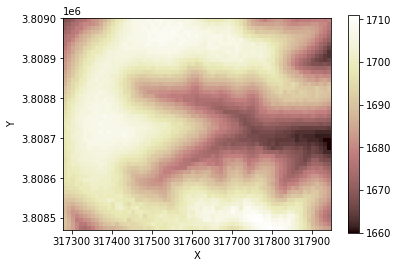

In [14]:
from landlab.plot import imshow_grid  
from landlab.io import read_esri_ascii  # reading an esri ascii file

(rmg,Z)=read_esri_ascii('Hugo_ws_10m.asc', name='topographic__elevation')  # let's use a new domain 
#and name it rmg and use Z for the elevation field

imshow_grid(rmg,'topographic__elevation')  

In [15]:
from landlab.components import FlowAccumulator

import matplotlib.pyplot as plt
from landlab.plot.drainage_plot import drainage_plot

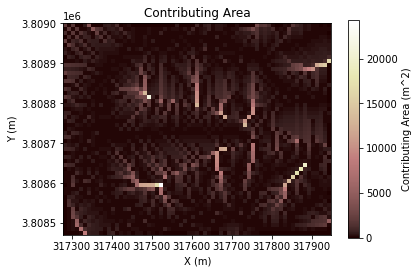

In [16]:
fa = FlowAccumulator(rmg, 'topographic__elevation', flow_director='D8')

fa.run_one_step()

plt.figure()

imshow_grid(rmg,'drainage_area', plot_name = 'Contributing Area', 
            var_name = 'Contributing Area', var_units = 'm^2', grid_units = ('m','m'))

As you can see here accumulated drainge areas do not connect to form a connected channel network. This is a common problem in DEMs when there are pits or small depressions in the DEM. In order for the water routed properly to the other side of a pit we will need to fill those depressionss. Landlab has several depression filler algorithms, below we use one of them:

In [19]:
from landlab.components import DepressionFinderAndRouter

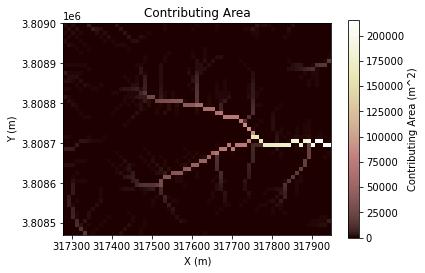

In [20]:
fa = FlowAccumulator(rmg,
                     surface='topographic__elevation',
                     flow_director='FlowDirectorD8',
                     runoff_rate=None,
                     depression_finder='DepressionFinderAndRouter')
fa.run_one_step()

plt.figure()

imshow_grid(rmg,'drainage_area', plot_name = 'Contributing Area', 
            var_name = 'Contributing Area', var_units = 'm^2', grid_units = ('m','m'))

# Conclusion

This tutorial compared the different methods in more detail and over surfaces that are more complicated than a simple sloping ramp. It also described how these different **FlowDirector** methods change the patterns of accumulated drainage area. 

Next consider one of two additional tutorials about directing and accumulating flow in Landlab.

1. **Introduction to FlowDirector**: A tutorial that goes over the different **FlowDirectors** present in Landlab and how to create and run a **FlowDirector**.
2. **Introduction to FlowAccumulator**: A tutorial that describes how to use the **FlowAccumulator**.

You can find these tutorials in the online notebooks binder. https://landlab.readthedocs.io/en/latest/user_guide/tutorials.html

## Exercise

Create a new JPN that:

* in your JPN use the function in box 3 to create a curved surface on a 15 by 15 domain.

* set the watershed boundary condition using the elevation field and identify the ID of the watershed outlet.

* run the D8 and DINF methods

* assess the outcome of setting the watershed boundary condition on the resulting drainage patterns compared to the exercise above.

* compare the calculated drainage area fields. Which method would you use if there is an incised channel in the middle of the hollow landscape. In your comparison you can map the differences between the calculated drainage area fields.

## Related tutorials 

Tutorials listed below can be found in the interactive notebook binder link:

* Introduction to the FlowDirector Components
* Introduction to the FlowAccumulator Component
* Comparison of FlowDirector Components

https://landlab.readthedocs.io/en/latest/user_guide/tutorials.html


